# **Analisis Regresi Performa Akademik Mahasiswa**
Mengeksplorasi dataset performa_mahasiswa.csv menggunakan Exploratory Data Analysis (EDA) untuk mendukung pembuatan model prediksi performa akademik. Analisis ini fokus pada pemeriksaan kualitas data, visualisasi distribusi, identifikasi hubungan antar-atribut, serta penyusunan rekomendasi terkait data tambahan yang mungkin diperlukan, dengan tujuan memahami pengaruh kebiasaan belajar dan gaya hidup mahasiswa terhadap performa akademik.

---

In [72]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np, math

drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/Dataset_Performa_Mahasiswa/performa_mahasiswa.csv'

def read_csv(path):
    try:
        df = pd.read_csv(path)
        print(f"File CSV berhasil dibaca dari {path}.")
        display(df.head())
        return df
    except FileNotFoundError:
        print(f"Error: File tidak ditemukan di {path}")
    except Exception as e:
        print(f"Terjadi kesalahan saat membaca file: {e}")

df = read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File CSV berhasil dibaca dari /content/drive/MyDrive/Colab Notebooks/Dataset_Performa_Mahasiswa/performa_mahasiswa.csv.


,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


## **1. Ringkasan Dataset**
Dataset memuat 1000 sampel (baris) dan 16 variabel (kolom). Variabel-variabel tersebut diklasifikasikan ke dalam empat kelompok: kebiasaan belajar, gaya hidup, demografi, dan nilai ujian. Selain itu, informasi mengenai tipe data setiap variabel dan ukuran file (±125,1 KB) turut dicatat.

---

In [73]:
# Lihat jumlah sampel dan variabel
print("Jumlah sampel (baris):", df.shape[0])
print("Jumlah variabel (kolom):", df.shape[1])

# Lihat tipe data setiap variabel
print("\nTipe data setiap variabel:")
print(df.info())

# Identifikasi variabel
kebiasaan_belajar = [
    'study_hours_per_day',
    'attendance_percentage',
    'parental_education_level',
    'internet_quality',
    'extracurricular_participation'
]

gaya_hidup = [
    'social_media_hours',
    'netflix_hours',
    'part_time_job',
    'sleep_hours',
    'diet_quality',
    'exercise_frequency',
    'mental_health_rating'
]

demografi = [
    'age',
    'gender',
    'student_id'
]

target = ['exam_score']

relevant_variables = kebiasaan_belajar + gaya_hidup + target

print("\nVariabel kebiasaan belajar:", kebiasaan_belajar)
print("Variabel gaya hidup:", gaya_hidup)
print("Variabel Demografi:", demografi)
print("Variabel target:", target)

Jumlah sampel (baris): 1000
Jumlah variabel (kolom): 16

Tipe data setiap variabel:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   student_id                     1000 non-null   object 
 1   age                            1000 non-null   int64  
 2   gender                         1000 non-null   object 
 3   study_hours_per_day            1000 non-null   float64
 4   social_media_hours             1000 non-null   float64
 5   netflix_hours                  1000 non-null   float64
 6   part_time_job                  1000 non-null   object 
 7   attendance_percentage          1000 non-null   float64
 8   sleep_hours                    1000 non-null   float64
 9   diet_quality                   1000 non-null   object 
 10  exercise_frequency             1000 non-null   int64  
 11  parental_education_level 

## **2. Validasi dan Standarisasi Data**

1. Standarisasi Teks Kategorial
→ Menyeragamkan format penulisan variabel kategorikal (misalnya huruf besar–kecil).
2. Validasi Rentang Variabel Numerik
→ Memastikan nilai variabel numerik seperti jam belajar, jam tidur, nilai ujian, dll. berada dalam rentang yang logis.
3. Validasi Nilai Variabel Kategorial
→ Mengecek apakah nilai variabel kategorikal sesuai dengan kategori yang diharapkan (misalnya gender hanya boleh Male atau Female).

---

In [74]:
# Standarisasi teks kategorial
kolom_kategorial_distandarisasi = [
    'gender',
    'part_time_job',
    'diet_quality',
    'parental_education_level',
    'internet_quality',
    'extracurricular_participation'
]

for col in kolom_kategorial_distandarisasi:
    if df[col].dtype == 'object':
        df[col] = df[col].str.title()

# Validasi rentang numerik
kolom_numerik_divalidasi = [
    "study_hours_per_day",
    "social_media_hours",
    "netflix_hours",
    "sleep_hours",
    "exam_score"
    ]

for col in kolom_numerik_divalidasi:
    if col == "exam_score":
        df = df[(df[col] >= 0) & (df[col] <= 100)]
    else:
        df = df[(df[col] >= 0) & (df[col] <= 24)]

df = df[(df["attendance_percentage"] >= 0) & (df["attendance_percentage"] <= 100)]
df = df[(df["mental_health_rating"] >= 1) & (df["mental_health_rating"] <= 10)]
df = df[(df["exercise_frequency"] >= 0)]


# Validasi nilai kategorial
kolom_kategorial_divalidasi = [
    'gender',
    'part_time_job',
    'diet_quality',
    'parental_education_level',
    'internet_quality',
    'extracurricular_participation'
]

nilai_yang_diharapkan = {
    'gender': ['Male', 'Female'],
    'part_time_job': ['Yes', 'No'],
    'diet_quality': ['Poor', 'Fair', 'Good'],
    'parental_education_level': ['High School', 'Bachelor', 'Master', 'Phd'],
    'internet_quality': ['Poor', 'Average', 'Good'],
    'extracurricular_participation': ['Yes', 'No']
}

for col in kolom_kategorial_divalidasi:
    nilai_tidak_terduga = df[~df[col].isin(nilai_yang_diharapkan[col])][col].unique()
    if len(nilai_tidak_terduga) > 0:
        print(f"Peringatan: Nilai tidak terduga ditemukan di '{col}': {nilai_tidak_terduga}")

Peringatan: Nilai tidak terduga ditemukan di 'gender': ['Other']
Peringatan: Nilai tidak terduga ditemukan di 'parental_education_level': [nan]


## **3. Evaluasi Kualitas Data (Missing Values & Outliers)**

1. Pemeriksaan Missing Values → Mengecek jumlah nilai kosong pada setiap variabel dan menentukan strategi penanganannya.

2. Statistik Deskriptif Variabel Numerik → Menampilkan ringkasan statistik (mean, median, min, max, std) untuk memahami distribusi data.

3. Metode Deteksi Outlier (IQR) → Menggunakan Interquartile Range untuk menentukan batas bawah dan atas, sehingga outlier dapat diidentifikasi.

4. Identifikasi Outlier pada Variabel Penting → Mendeteksi data ekstrem pada variabel numerik utama seperti jam belajar, jam tidur, media sosial, dan skor ujian.

5. Hasil Deteksi Outlier → Menyajikan jumlah outlier per variabel dan memutuskan apakah harus dihapus atau ditangani.

6. Visualisasi Outlier dengan Boxplot → Memvisualisasikan distribusi variabel numerik dan posisi outlier secara grafis.

---


Missing values per variabel:
student_id                        0
age                               0
gender                            0
study_hours_per_day               0
social_media_hours                0
netflix_hours                     0
part_time_job                     0
attendance_percentage             0
sleep_hours                       0
diet_quality                      0
exercise_frequency                0
parental_education_level         91
internet_quality                  0
mental_health_rating              0
extracurricular_participation     0
exam_score                        0
dtype: int64

Statistik deskriptif untuk variabel numerik yang relevan (untuk cek potensi outlier):
             age  study_hours_per_day  attendance_percentage  \
count  1000.0000           1000.00000            1000.000000   
mean     20.4980              3.55010              84.131700   
std       2.3081              1.46889               9.399246   
min      17.0000              0.00000 

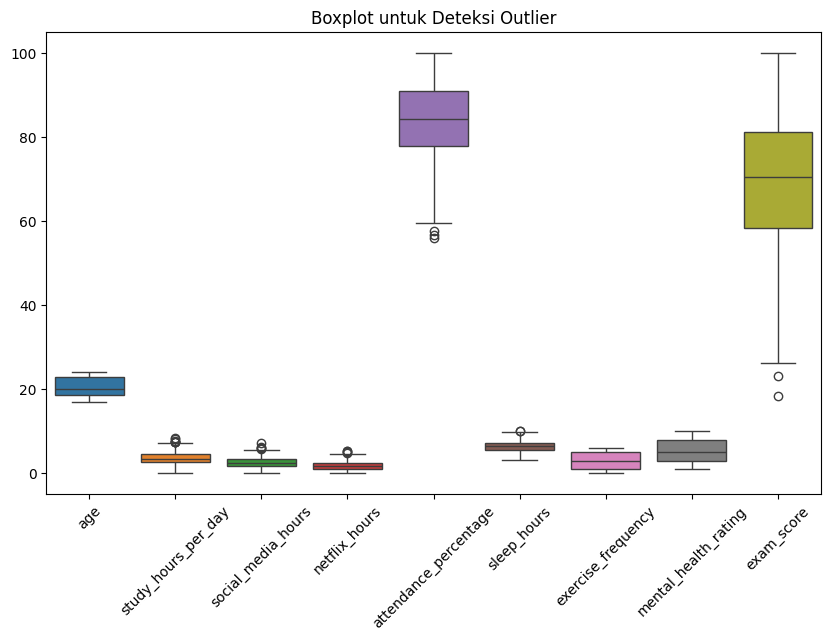

In [75]:
# Cek missing values
print("\nMissing values per variabel:")
print(df.isnull().sum())

# Menggambarkan distribusi data
print("\nStatistik deskriptif untuk variabel numerik yang relevan (untuk cek potensi outlier):")
print(df[demografi + kebiasaan_belajar + gaya_hidup + target].describe())

# Fungsi untuk mencari outlier
def find_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower) | (df[col] > upper)][[col]]
    outliers = outliers.copy()
    outliers["row_number"] = outliers.index + 1  # mulai dari 1
    return outliers

# Gabung semua outlier jadi satu dict
outlier_dict = {}
for col in ['age','study_hours_per_day','social_media_hours','netflix_hours',
            'attendance_percentage','sleep_hours','exercise_frequency',
            'mental_health_rating','exam_score']:
    outlier_dict[col] = find_outliers(df, col)

# Tampilkan hasil
for k, v in outlier_dict.items():
    print(f"\nOutlier di {k}:")
    print(v)

# Visualisasi outliers
plt.figure(figsize=(10,6))
sns.boxplot(data=df[['age','study_hours_per_day','social_media_hours','netflix_hours',
            'attendance_percentage','sleep_hours','exercise_frequency',
            'mental_health_rating','exam_score']])
plt.xticks(rotation=45)
plt.title("Boxplot untuk Deteksi Outlier")
plt.show()

## **4. Data Cleaning untuk Menangani Nilai yang Hilang**
Kita akan menangani nilai yang hilang (missing values) pada kolom numerik yang telah teridentifikasi dengan menggunakan metode imputasi.
Langkah yang dilakukan adalah mencari modus (nilai yang paling sering muncul) pada setiap kolom, kemudian menggunakan nilai tersebut untuk mengisi semua sel yang kosong.
Sebagai tahap akhir, dilakukan verifikasi untuk memastikan bahwa tidak ada lagi data yang hilang.

---

In [76]:
print("--- Proses Imputasi Dimulai ---")
# Hitung modus (nilai paling sering muncul) dari kolom
modus_pendidikan = df['parental_education_level'].mode()[0]
print(f"Modus (tingkat pendidikan orang tua yang paling umum): '{modus_pendidikan}'")

# Isi nilai kosong (NaN) di kolom tersebut dengan nilai modus
df['parental_education_level'].fillna(modus_pendidikan, inplace=True)
print("\n--- Proses Imputasi Selesai ✅ ---")

# Verifikasi untuk memastikan sudah tidak ada nilai kosong
missing_values_after = df['parental_education_level'].isnull().sum()
print(f"Jumlah missing values di kolom 'parental_education_level' sekarang: {missing_values_after}")

# Cek missing values
print("\nMissing values per variabel:")
print(df.isnull().sum())

--- Proses Imputasi Dimulai ---
Modus (tingkat pendidikan orang tua yang paling umum): 'High School'

--- Proses Imputasi Selesai ✅ ---
Jumlah missing values di kolom 'parental_education_level' sekarang: 0

Missing values per variabel:
student_id                       0
age                              0
gender                           0
study_hours_per_day              0
social_media_hours               0
netflix_hours                    0
part_time_job                    0
attendance_percentage            0
sleep_hours                      0
diet_quality                     0
exercise_frequency               0
parental_education_level         0
internet_quality                 0
mental_health_rating             0
extracurricular_participation    0
exam_score                       0
dtype: int64


/tmp/ipython-input-556006680.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['parental_education_level'].fillna(modus_pendidikan, inplace=True)


## **5. Data Cleaning untuk Menangani Outlier**
Kita akan menangani outlier pada kolom-kolom numerik yang telah ditentukan dengan menerapkan metode capping berbasis Interquartile Range (IQR). Secara spesifik, prosesnya adalah:

*   Menghitung batas atas dan batas bawah yang wajar untuk setiap kolom menggunakan rumus statistik (Q1 - 1.5 * IQR dan Q3 + 1.5 * IQR).
*   Setiap nilai yang lebih ekstrem dari batas tersebut akan secara otomatis digantikan dengan nilai batasnya (nilai yang terlalu tinggi diganti dengan batas atas, dan yang terlalu rendah diganti dengan batas bawah).
*   Tujuan utamanya adalah membersihkan data dari nilai-nilai anomali yang dapat mengganggu analisis atau performa model, tanpa harus menghapus baris data tersebut.

---


--- Proses Capping Outlier Dimulai ---
Outlier di kolom 'study_hours_per_day' telah ditangani.
Outlier di kolom 'social_media_hours' telah ditangani.
Outlier di kolom 'netflix_hours' telah ditangani.
Outlier di kolom 'attendance_percentage' telah ditangani.
Outlier di kolom 'sleep_hours' telah ditangani.
Outlier di kolom 'exam_score' telah ditangani.

--- Proses Capping Outlier Selesai ✅ ---

Statistik deskriptif setelah capping:
       study_hours_per_day  social_media_hours  netflix_hours  \
count          1000.000000          1000.00000    1000.000000   
mean              3.547750             2.50280       1.818350   
std               1.462202             1.16385       1.071056   
min               0.000000             0.00000       0.000000   
25%               2.600000             1.70000       1.000000   
50%               3.500000             2.50000       1.800000   
75%               4.500000             3.30000       2.525000   
max               7.350000             5.70000

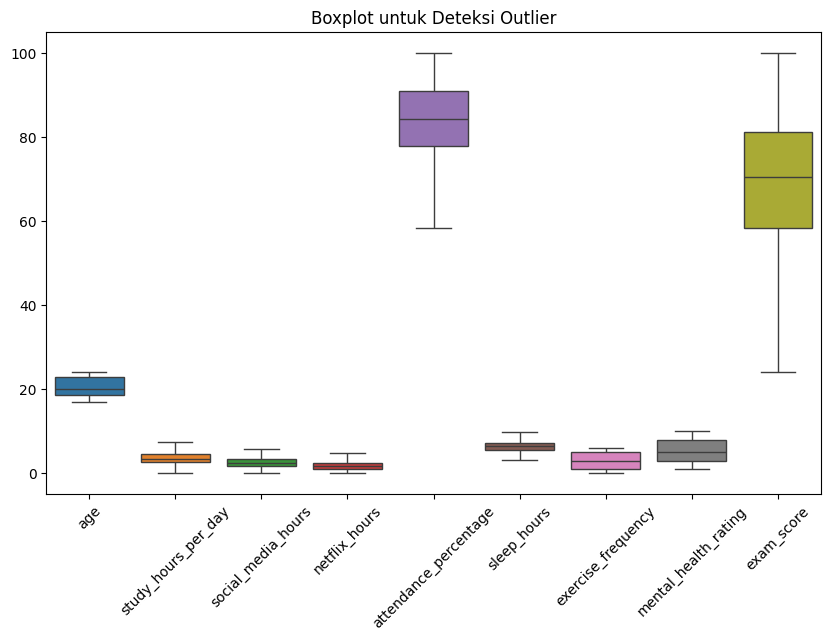


Outlier di age:
Empty DataFrame
Columns: [age, row_number]
Index: []

Outlier di study_hours_per_day:
Empty DataFrame
Columns: [study_hours_per_day, row_number]
Index: []

Outlier di social_media_hours:
Empty DataFrame
Columns: [social_media_hours, row_number]
Index: []

Outlier di netflix_hours:
Empty DataFrame
Columns: [netflix_hours, row_number]
Index: []

Outlier di attendance_percentage:
Empty DataFrame
Columns: [attendance_percentage, row_number]
Index: []

Outlier di sleep_hours:
Empty DataFrame
Columns: [sleep_hours, row_number]
Index: []

Outlier di exercise_frequency:
Empty DataFrame
Columns: [exercise_frequency, row_number]
Index: []

Outlier di mental_health_rating:
Empty DataFrame
Columns: [mental_health_rating, row_number]
Index: []

Outlier di exam_score:
Empty DataFrame
Columns: [exam_score, row_number]
Index: []


In [77]:
# Tentukan kolom numerik yang akan ditangani outlier-nya. Berdasarkan output sebelumnya.
columns_to_cap = [
    'study_hours_per_day',
    'social_media_hours',
    'netflix_hours',
    'attendance_percentage',
    'sleep_hours',
    'exam_score'
]

print("--- Proses Capping Outlier Dimulai ---")

# Loop melalui setiap kolom untuk melakukan capping
for column in columns_to_cap:
    # Hitung Q1, Q3, dan IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Tentukan batas bawah dan batas atas
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Lakukan capping
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

    print(f"Outlier di kolom '{column}' telah ditangani.")

print("\n--- Proses Capping Outlier Selesai ✅ ---")

# Verifikasi dengan melihat statistik deskriptif lagi
print("\nStatistik deskriptif setelah capping:")
print(df[columns_to_cap].describe())

# Visualisasi outliers
plt.figure(figsize=(10,6))
sns.boxplot(data=df[['age','study_hours_per_day','social_media_hours','netflix_hours',
            'attendance_percentage','sleep_hours','exercise_frequency',
            'mental_health_rating','exam_score']])
plt.xticks(rotation=45)
plt.title("Boxplot untuk Deteksi Outlier")
plt.show()

# Fungsi untuk mencari outlier
def find_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower) | (df[col] > upper)][[col]]
    outliers = outliers.copy()
    outliers["row_number"] = outliers.index + 1
    return outliers

# Gabung semua outlier jadi satu dict
outlier_dict = {}
for col in ['age','study_hours_per_day','social_media_hours','netflix_hours',
            'attendance_percentage','sleep_hours','exercise_frequency',
            'mental_health_rating','exam_score']:
    outlier_dict[col] = find_outliers(df, col)

# Tampilkan hasil
for k, v in outlier_dict.items():
    print(f"\nOutlier di {k}:")
    print(v)

## **6. Visualisasi Data Numerik dan Kategorial**
Visualisasi data numerik akan ditampilkan dalam bentuk histogram untuk variabel: age, study_hours_per_day, social_media_hours, netflix_hours, attendance_percentage, sleep_hours, exercise_frequency, mental_health_rating, dan exam_score.

Sementara itu, visualisasi data kategorikal akan dipetakan menggunakan barplot untuk variabel: gender, part_time_job, diet_quality, parental_education_level, internet_quality, dan extracurricular_participation.

---

--- Visualisasi Kolom Numerik (Histogram) ---


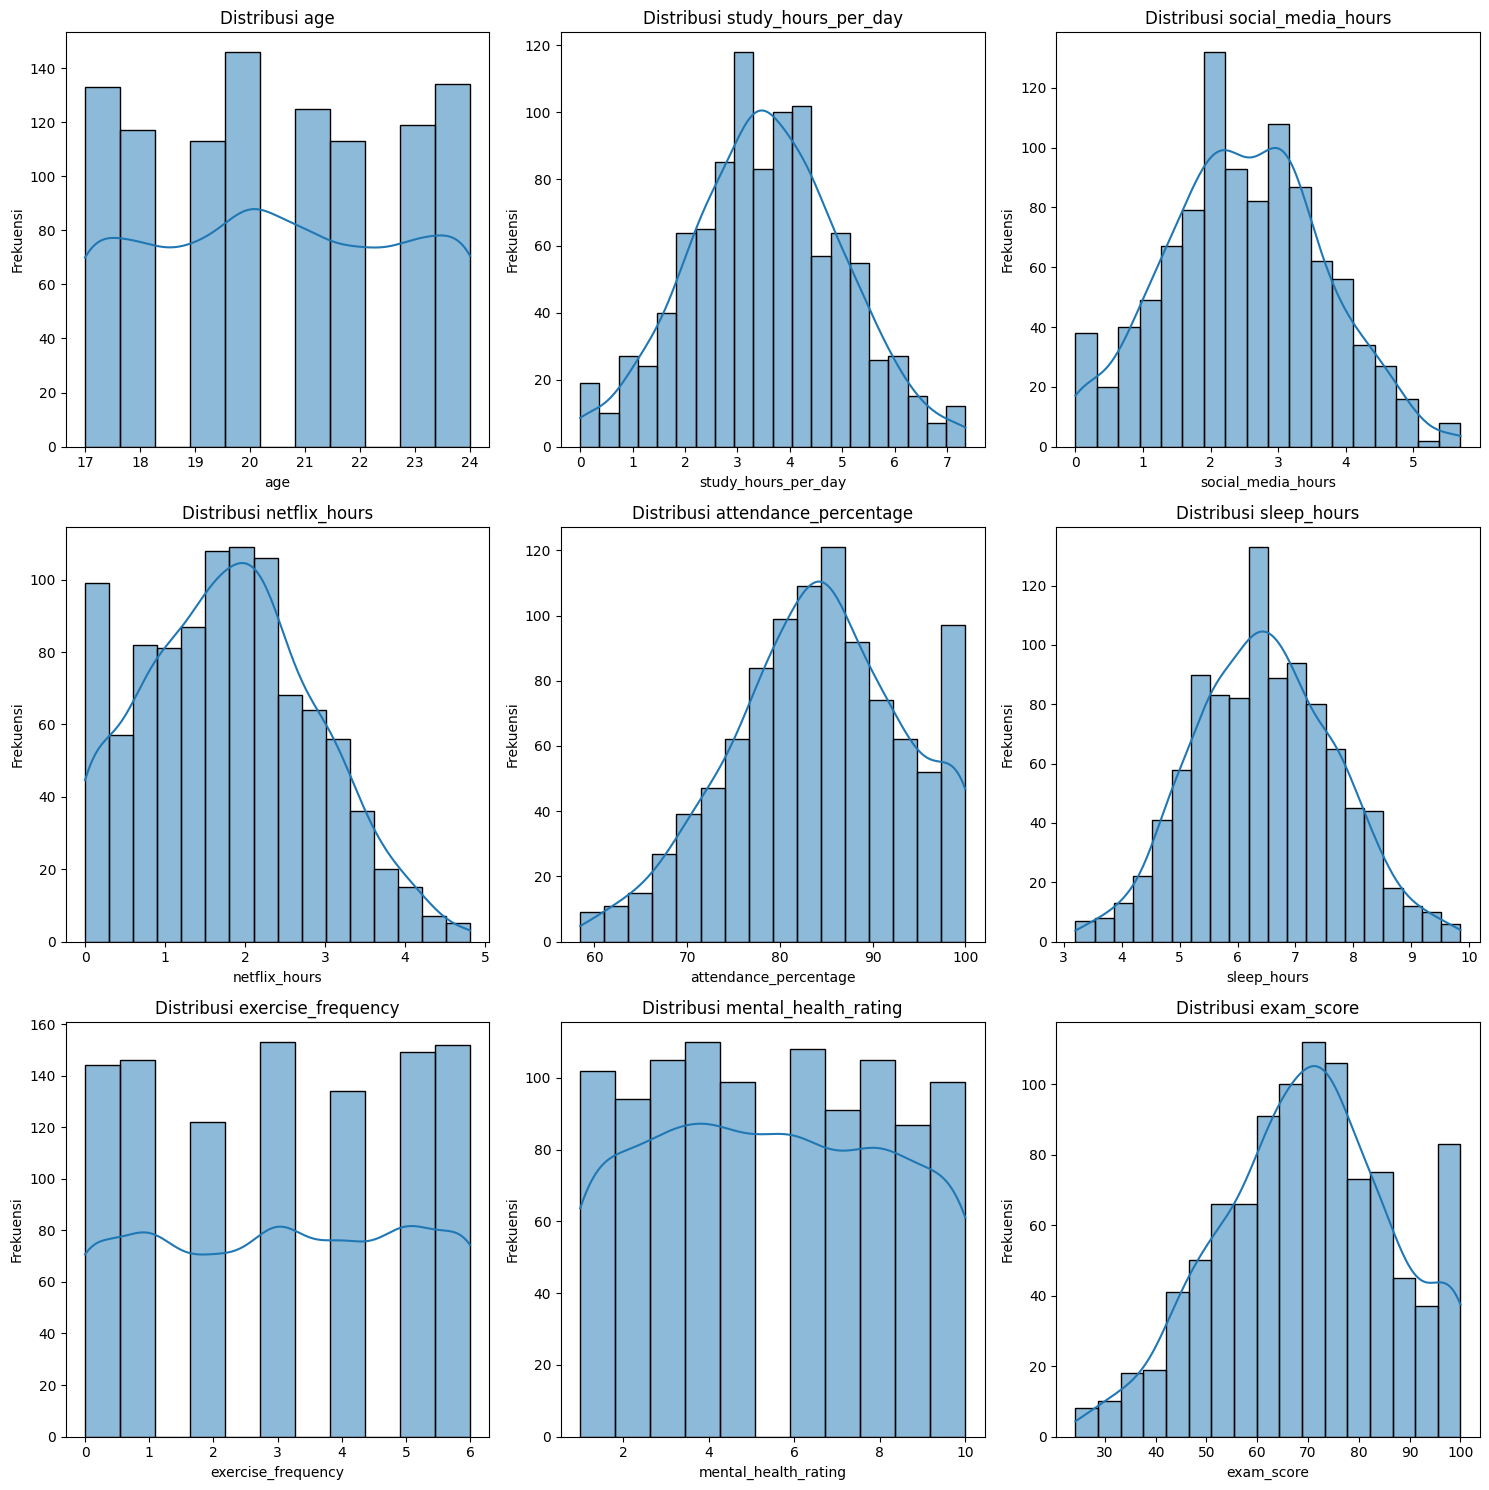


--- Visualisasi Kolom Kategorikal (Bar Plot) ---


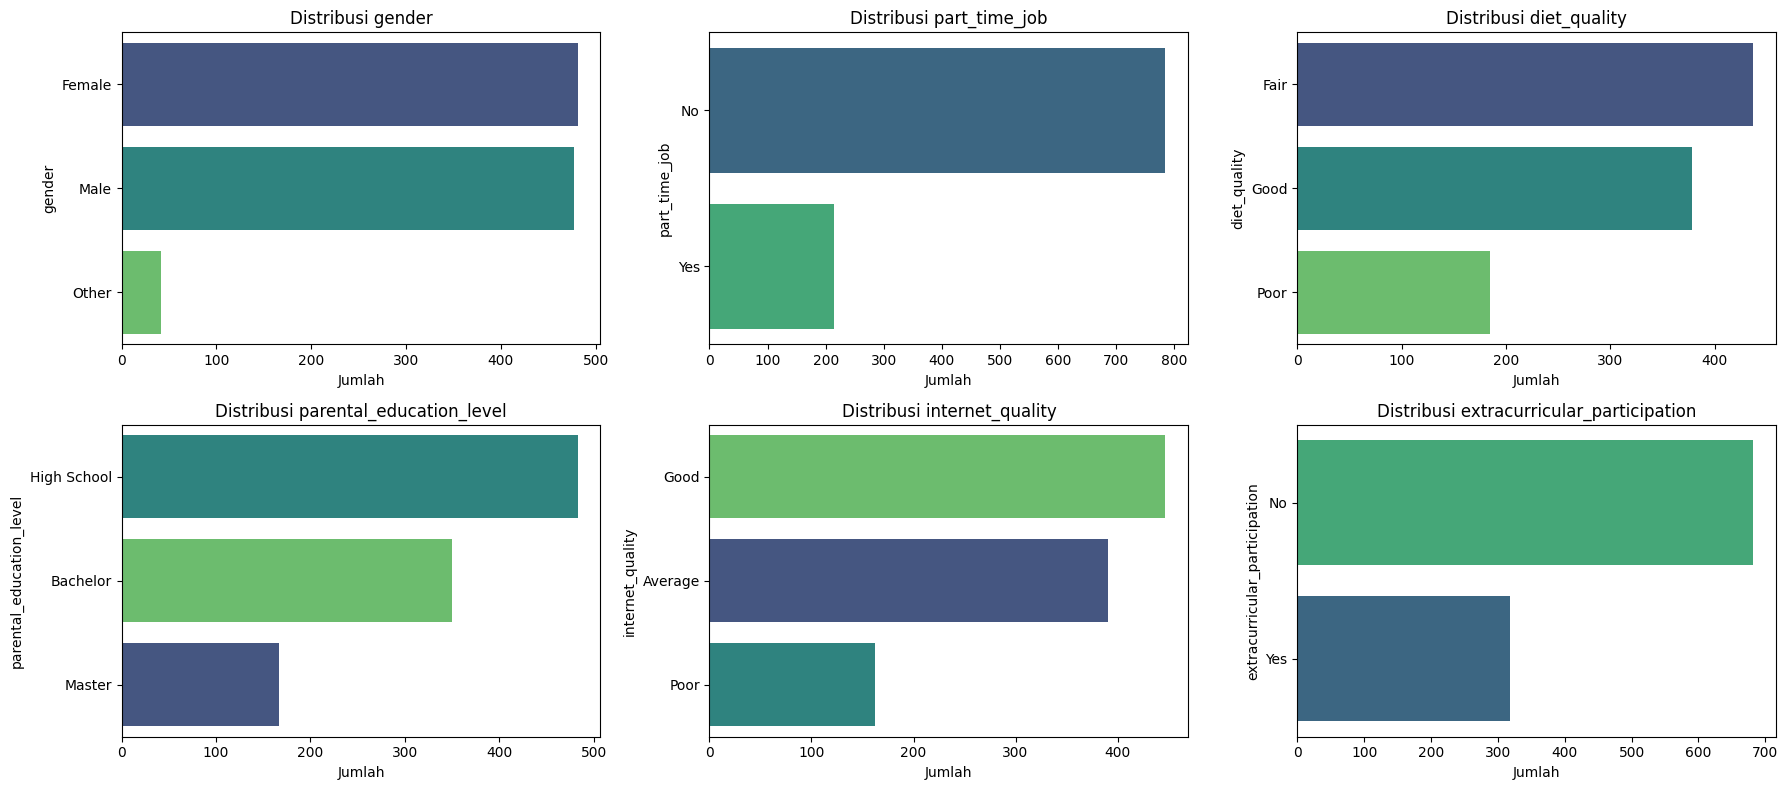

In [78]:
# Visualisasi data numerik dalam histogram
Numerik = df.select_dtypes(include=np.number).columns.tolist()
print("--- Visualisasi Kolom Numerik (Histogram) ---")

n_cols = 3
n_rows = (len(Numerik) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

for i, col in enumerate(Numerik):
    sns.histplot(data=df, x=col, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribusi {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frekuensi')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# Visualisasi data kategorial dalam bar plot
kategorial = df.select_dtypes(include='object').columns.tolist()
# Menghilangkan kategorial student_id
kategorial.remove('student_id')

print("\n--- Visualisasi Kolom Kategorikal (Bar Plot) ---")
ncols = 3
nrows = math.ceil(len(kategorial) / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(18, nrows * 4))
axes = axes.flatten()

for i, col in enumerate(kategorial):
    sns.countplot(data=df, y=col, order=df[col].value_counts().index, palette='viridis', hue=col, legend=False, ax=axes[i])
    axes[i].set_title(f'Distribusi {col}', fontsize=12)
    axes[i].set_xlabel('Jumlah')
    axes[i].set_ylabel(col)

for i in range(len(kategorial), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## **7. Analisis Statistik Determinan Prestasi Akademik Mahaiswa**
Skrip analisis statistik yang mengevaluasi pengaruh variabel eksternal—seperti durasi tidur, paparan media sosial, dan latar belakang orang tua—terhadap hasil ujian mahasiswa. Kode ini menggunakan metode korelasi Pearson dan komparasi grup (grouping) untuk memvalidasi hipotesis mengenai keseimbangan kehidupan siswa dan performa akademis.

---

In [79]:
# 1. Rata-rata jam belajar per hari
avg_study_hours = df['study_hours_per_day'].mean()
print(f"1. Rata-rata jam belajar per hari mahasiswa: {avg_study_hours:.2f} jam")

# 2. Perbedaan rata-rata nilai ujian antara mahasiswa dengan pekerjaan paruh waktu dan tidak
exam_score_part_time = df.groupby('part_time_job')['exam_score'].mean()
print("\n2. Rata-rata nilai ujian berdasarkan pekerjaan paruh waktu:")
print(exam_score_part_time)

# 3. Rata-rata jam tidur mahasiswa
avg_sleep_hours = df['sleep_hours'].mean()
print(f"\n3. Rata-rata jam tidur mahasiswa setiap hari: {avg_sleep_hours:.2f} jam")

# 4. Perbandingan jam media sosial dan Netflix
avg_social_media = df['social_media_hours'].mean()
avg_netflix = df['netflix_hours'].mean()
print(f"\n4. Rata-rata jam media sosial: {avg_social_media:.2f} jam")
print(f"   Rata-rata jam Netflix: {avg_netflix:.2f} jam")
if avg_social_media > avg_netflix:
    print("   Media sosial lebih banyak menyita waktu mahasiswa dibandingkan Netflix.")
elif avg_netflix > avg_social_media:
    print("   Netflix lebih banyak menyita waktu mahasiswa dibandingkan media sosial.")
else:
    print("   Waktu yang dihabiskan untuk media sosial dan Netflix rata-rata sama.")

# 5. Persentase mahasiswa dengan tingkat kehadiran di bawah 75%
students_below_75_attendance = df[df['attendance_percentage'] < 75]
percentage_below_75 = (len(students_below_75_attendance) / len(df)) * 100
print(f"\n5. Persentase mahasiswa dengan tingkat kehadiran di bawah 75%: {percentage_below_75:.2f}%")

# Korelasi antara jam belajar dan nilai ujian
correlation_study_exam = df['study_hours_per_day'].corr(df['exam_score'])
print(f"\n6. Korelasi antara jam belajar per hari dan nilai ujian: {correlation_study_exam:.2f}")
if correlation_study_exam > 0.5: # Menggunakan threshold 0.5 sebagai indikasi korelasi positif yang kuat
    print("   Terdapat korelasi positif yang kuat antara jam belajar per hari dan nilai ujian, menunjukkan mahasiswa yang lebih banyak belajar cenderung memiliki nilai ujian lebih tinggi.")
elif correlation_study_exam < -0.5:
     print("   Terdapat korelasi negatif yang kuat antara jam belajar per hari dan nilai ujian.")
else:
    print("   Korelasi antara jam belajar per hari dan nilai ujian tidak terlalu kuat.")

# Korelasi dan Analisis Jam Tidur vs Nilai Ujian (dengan threshold 6 jam)
print(f"\n7. Korelasi dan Analisis Jam Tidur vs Nilai Ujian (dengan threshold 6 jam)")
correlation_sleep_exam = df['sleep_hours'].corr(df['exam_score'])
print(f"\n   Korelasi antara jam tidur dan nilai ujian: {correlation_sleep_exam:.2f}")
if correlation_sleep_exam < 0:
    print("  Terdapat korelasi negatif antara jam tidur dan nilai ujian, menunjukkan jam tidur yang lebih sedikit mungkin berdampak pada nilai ujian yang lebih rendah.")
else:
    print("   Korelasi antara jam tidur dan nilai ujian tidak menunjukkan dampak yang jelas.")

sleep_less_than_6 = df[df['sleep_hours'] < 6]['exam_score'].mean()
sleep_greater_equal_6 = df[df['sleep_hours'] >= 6]['exam_score'].mean()

print(f"\n   Rata-rata nilai ujian mahasiswa dengan jam tidur < 6 jam: {sleep_less_than_6:.2f}")
print(f"   Rata-rata nilai ujian mahasiswa dengan jam tidur >= 6 jam: {sleep_greater_equal_6:.2f}")
if sleep_less_than_6 < sleep_greater_equal_6:
    print("   Rata-rata nilai ujian lebih rendah untuk mahasiswa dengan jam tidur kurang dari 6 jam.")
else:
    print("   Rata-rata nilai ujian tidak jauh berbeda atau lebih tinggi untuk mahasiswa dengan jam tidur kurang dari 6 jam.")

# Korelasi dan Analisis Penggunaan Media Sosial vs Nilai Ujian (dengan threshold 4 jam)
print(f"\n8. Korelasi dan Analisis Penggunaan Media Sosial vs Nilai Ujian (dengan threshold 4 jam)")
correlation_social_media_exam = df['social_media_hours'].corr(df['exam_score'])
print(f"\n   Korelasi antara jam media sosial dan nilai ujian: {correlation_social_media_exam:.2f}")
if correlation_social_media_exam < 0:
    print("   Terdapat korelasi negatif antara jam media sosial dan nilai ujian, menunjukkan penggunaan media sosial yang tinggi mungkin terkait dengan nilai ujian yang lebih rendah.")
else:
    print("   Korelasi antara jam media sosial dan nilai ujian tidak menunjukkan dampak negatif yang jelas.")

social_media_less_than_4 = df[df['social_media_hours'] < 4]['exam_score'].mean()
social_media_greater_equal_4 = df[df['social_media_hours'] >= 4]['exam_score'].mean()

print(f"\n   Rata-rata nilai ujian mahasiswa dengan penggunaan media sosial < 4 jam: {social_media_less_than_4:.2f}")
print(f"   Rata-rata nilai ujian mahasiswa dengan penggunaan media sosial >= 4 jam: {social_media_greater_equal_4:.2f}")
if social_media_greater_equal_4 < social_media_less_than_4:
    print("   Rata-rata nilai ujian lebih rendah untuk mahasiswa dengan penggunaan media sosial lebih dari atau sama dengan 4 jam.")
else:
    print("   Rata-rata nilai ujian tidak jauh berbeda atau lebih tinggi untuk mahasiswa dengan penggunaan media sosial lebih dari atau sama dengan 4 jam.")


# Rata-rata nilai ujian berdasarkan tingkat pendidikan orang tua
print("\n9. Rata-rata nilai ujian berdasarkan tingkat pendidikan orang tua:")
exam_score_parental_education = df.groupby('parental_education_level')['exam_score'].mean()
print(exam_score_parental_education)

# Rata-rata nilai ujian berdasarkan kualitas internet
exam_score_internet_quality = df.groupby('internet_quality')['exam_score'].mean()
print("\n10. Rata-rata nilai ujian berdasarkan kualitas internet:")
print(exam_score_internet_quality)

# Rata-rata nilai ujian berdasarkan partisipasi ekstrakurikuler
exam_score_extracurricular = df.groupby('extracurricular_participation')['exam_score'].mean()
print("\n11. Rata-rata nilai ujian berdasarkan partisipasi ekstrakurikuler:")
print(exam_score_extracurricular)

1. Rata-rata jam belajar per hari mahasiswa: 3.55 jam

2. Rata-rata nilai ujian berdasarkan pekerjaan paruh waktu:
part_time_job
No     69.845350
Yes    68.743256
Name: exam_score, dtype: float64

3. Rata-rata jam tidur mahasiswa setiap hari: 6.47 jam

4. Rata-rata jam media sosial: 2.50 jam
   Rata-rata jam Netflix: 1.82 jam
   Media sosial lebih banyak menyita waktu mahasiswa dibandingkan Netflix.

5. Persentase mahasiswa dengan tingkat kehadiran di bawah 75%: 16.80%

6. Korelasi antara jam belajar per hari dan nilai ujian: 0.83
   Terdapat korelasi positif yang kuat antara jam belajar per hari dan nilai ujian, menunjukkan mahasiswa yang lebih banyak belajar cenderung memiliki nilai ujian lebih tinggi.

7. Korelasi dan Analisis Jam Tidur vs Nilai Ujian (dengan threshold 6 jam)

   Korelasi antara jam tidur dan nilai ujian: 0.12
   Korelasi antara jam tidur dan nilai ujian tidak menunjukkan dampak yang jelas.

   Rata-rata nilai ujian mahasiswa dengan jam tidur < 6 jam: 67.57
   Rata-

## **8. Analisis Visual Hubungan Variabel: Scatter Plot & Heatmap Korelasi**
Bagian ini memvisualisasikan pola hubungan antar variabel menggunakan dua pendekatan: Scatter Plot untuk mengamati linearitas persebaran data secara detail, dan Heatmap untuk menampilkan matriks korelasi (Pearson) secara menyeluruh dalam representasi warna, sehingga faktor yang paling berpengaruh terhadap nilai ujian dapat teridentifikasi dengan cepat.

---

--- Visualisasi Hubungan Antara Potensi Prediktor Numerik dan Exam Score (Scatter Plot) ---


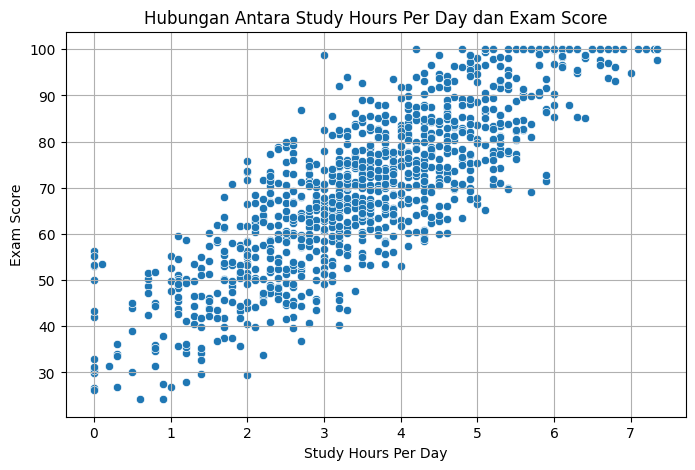

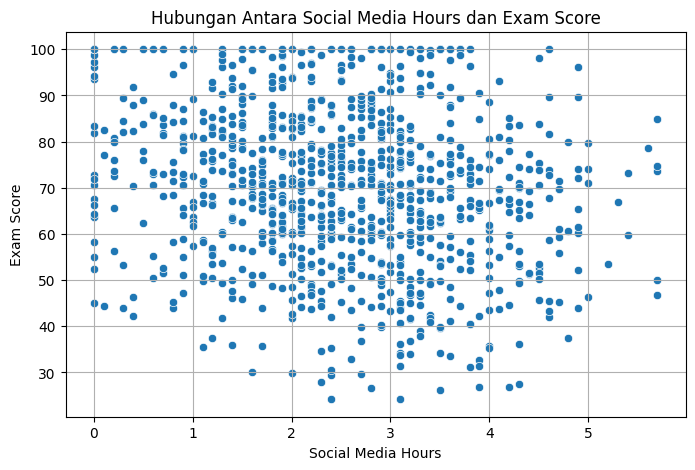

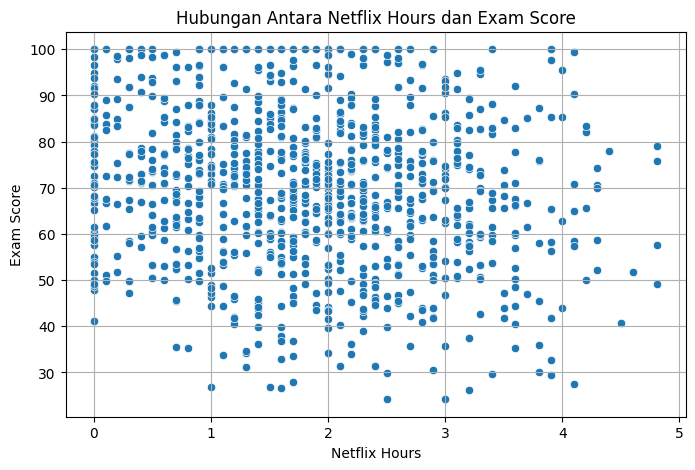

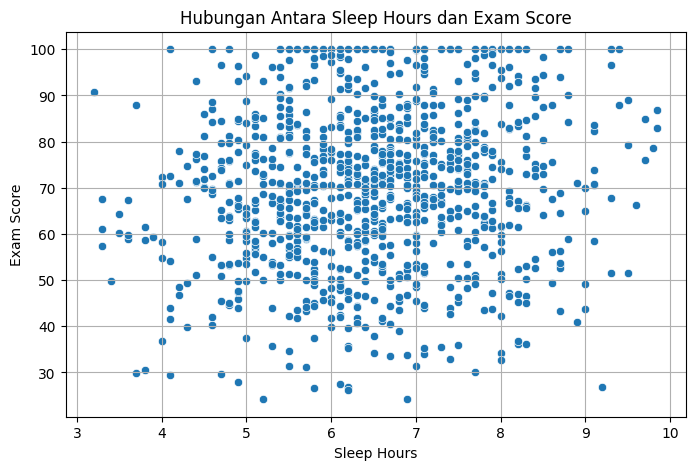

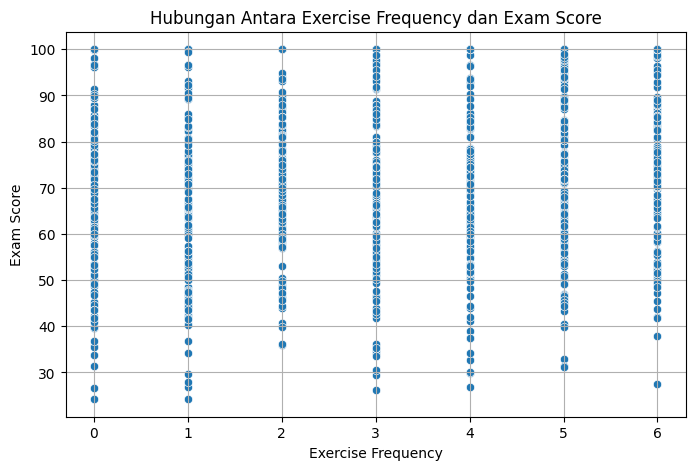

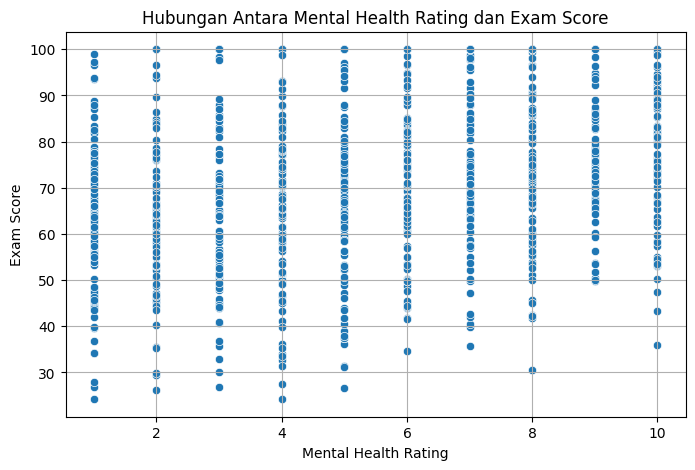

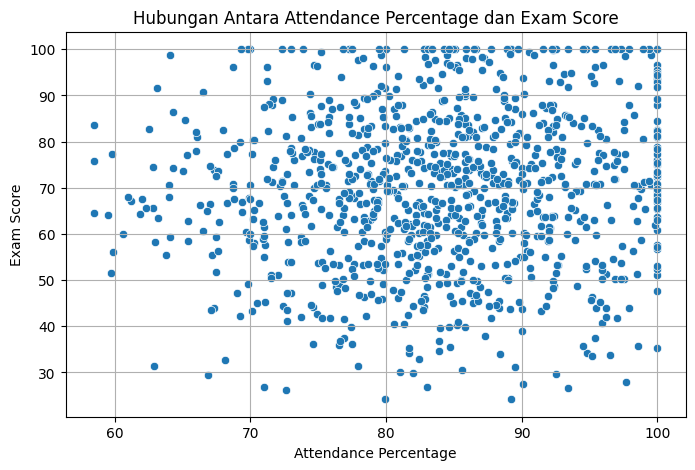

In [80]:
# Kolom numerik yang berpotensi menjadi prediktor (berdasarkan korelasi dan relevansi)
potential_predictors_numeric = [
    'study_hours_per_day',
    'social_media_hours',
    'netflix_hours',
    'sleep_hours',
    'exercise_frequency',
    'mental_health_rating',
    'attendance_percentage'
]

print("--- Visualisasi Hubungan Antara Potensi Prediktor Numerik dan Exam Score (Scatter Plot) ---")

# Scatter plot untuk setiap potensi prediktor numerik terhadap exam_score
for col in potential_predictors_numeric:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x=col, y='exam_score')
    plt.title(f'Hubungan Antara {col.replace("_", " ").title()} dan Exam Score')
    plt.xlabel(col.replace("_", " ").title())
    plt.ylabel('Exam Score')
    plt.grid(True)
    plt.show()

--- Heatmap Koefisien Korelasi ---


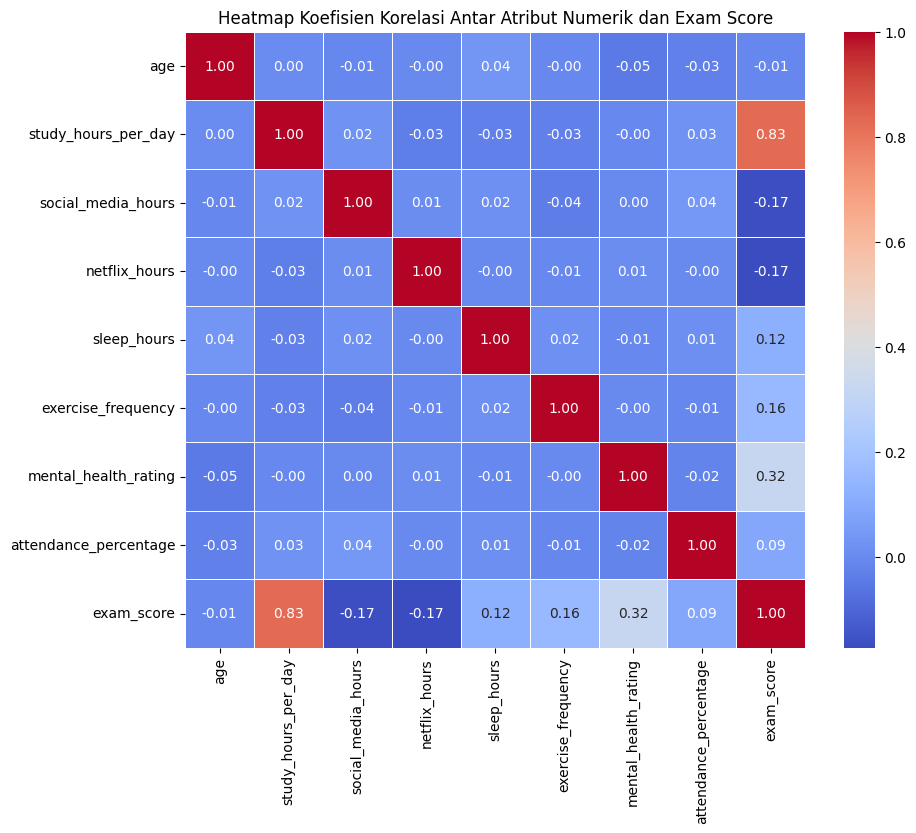

In [81]:
# Prediktor potensial yang sudah di pilih
prediktor_potensial_and_target = [
    'age',
    'study_hours_per_day',
    'social_media_hours',
    'netflix_hours',
    'sleep_hours',
    'exercise_frequency',
    'mental_health_rating',
    'attendance_percentage',
    'exam_score'
]

# Korelasi matriks
korelasi_matriks = df[prediktor_potensial_and_target].corr()

print("--- Heatmap Koefisien Korelasi ---")

plt.figure(figsize=(10, 8))
sns.heatmap(korelasi_matriks, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap Koefisien Korelasi Antar Atribut Numerik dan Exam Score')
plt.show()

## **9. Pipeline Regresi Linear Sederhana: Perbandingan Validasi Split vs K-Fold**
Looping otomatis yang melatih model regresi pada setiap fitur dalam daftar simple_predictors. Kode ini menghasilkan tabel perbandingan performa model menggunakan metode validasi statis (hold-out) dan dinamis (cross-validation) untuk mengukur stabilitas model.

---

In [82]:
# ================================
# SIMPLE LINEAR REGRESSION
# ================================

# Variabel target
y = df['exam_score']

# Daftar atribut prediktor tunggal
simple_predictors = [
    'study_hours_per_day',
    'social_media_hours',
    'sleep_hours',
    'mental_health_rating',
    'exercise_frequency',
    'netflix_hours'
]

# K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# -------------------------------
# Evaluasi Train/Test Split
# -------------------------------
results_tt = []

for col in simple_predictors:
    X = df[[col]]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = math.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results_tt.append([
        col,
        round(mae, 3),
        round(mse, 3),
        round(rmse, 3),
        round(r2, 3),
        "—"
    ])

df_train_test = pd.DataFrame(results_tt, columns=[
    "Atribut Prediktor", "MAE", "MSE", "RMSE", "R2", "Keterangan"
])

print("=== SIMPLE LINEAR REGRESSION — HASIL TRAIN/TEST ===")
display(df_train_test)


# -------------------------------
# Evaluasi K-Fold Cross Validation
# -------------------------------
results_kf = []

for col in simple_predictors:
    X = df[[col]]
    maes, mses, rmses, r2s = [], [], [], []

    for train_idx, test_idx in kf.split(X):
        Xtr, Xte = X.iloc[train_idx], X.iloc[test_idx]
        ytr, yte = y.iloc[train_idx], y.iloc[test_idx]

        mk = LinearRegression().fit(Xtr, ytr)
        y_pred = mk.predict(Xte)

        maes.append(mean_absolute_error(yte, y_pred))
        mses.append(mean_squared_error(yte, y_pred))
        rmses.append(math.sqrt(mean_squared_error(yte, y_pred)))
        r2s.append(r2_score(yte, y_pred))

    results_kf.append([
        col,
        round(np.mean(maes), 3),
        round(np.mean(mses), 3),
        round(np.mean(rmses), 3),
        round(np.mean(r2s), 3),
        f"k={kf.get_n_splits()}"
    ])

df_kfold = pd.DataFrame(results_kf, columns=[
    "Atribut Prediktor", "Rata-rata MAE", "Rata-rata MSE", "Rata-rata RMSE", "Rata-rata R2", "Keterangan"
])

print("\n=== SIMPLE LINEAR REGRESSION — HASIL K-FOLD CROSS VALIDATION ===")
display(df_kfold)


=== SIMPLE LINEAR REGRESSION — HASIL TRAIN/TEST ===


,Atribut Prediktor,MAE,MSE,RMSE,R2,Keterangan
0,study_hours_per_day,7.395,83.852,9.157,0.669,—
1,social_media_hours,12.584,258.890,16.090,-0.023,—
2,sleep_hours,12.264,251.732,15.866,0.006,—
3,mental_health_rating,12.088,233.430,15.278,0.078,—
4,exercise_frequency,12.170,243.225,15.596,0.039,—
5,netflix_hours,12.065,245.229,15.660,0.031,—



=== SIMPLE LINEAR REGRESSION — HASIL K-FOLD CROSS VALIDATION ===


,Atribut Prediktor,Rata-rata MAE,Rata-rata MSE,Rata-rata RMSE,Rata-rata R2,Keterangan
0,study_hours_per_day,7.700,90.594,9.495,0.676,k=5
1,social_media_hours,13.454,277.411,16.642,0.020,k=5
2,sleep_hours,13.465,280.794,16.738,0.010,k=5
3,mental_health_rating,12.811,255.558,15.971,0.098,k=5
4,exercise_frequency,13.538,279.223,16.696,0.013,k=5
5,netflix_hours,13.378,276.638,16.610,0.025,k=5


## **10. Pipeline Regresi Linear Berganda: Komparasi 5 Skenario Kombinasi Fitur**
Modul evaluasi iteratif yang menguji lima variasi model dengan jumlah prediktor bertingkat (dari 2 hingga 6 fitur). Kode ini membandingkan akurasi setiap kombinasi model menggunakan metode validasi statis (Train/Test) dan dinamis (K-Fold Cross Validation) untuk menentukan kumpulan fitur yang memberikan performa terbaik.

---

In [83]:
# ================================
# MULTIPLE LINEAR REGRESSION
# ================================

# Variabel target
y = df['exam_score']

# Definisi kombinasi fitur untuk setiap model
multi_models = {
    "Model 1": ['study_hours_per_day', 'social_media_hours'],
    "Model 2": ['study_hours_per_day', 'social_media_hours', 'sleep_hours'],
    "Model 3": ['study_hours_per_day', 'social_media_hours', 'mental_health_rating', 'sleep_hours'],
    "Model 4": ['study_hours_per_day', 'social_media_hours', 'mental_health_rating', 'sleep_hours', 'exercise_frequency'],
    "Model 5": ['study_hours_per_day', 'social_media_hours', 'mental_health_rating', 'sleep_hours', 'exercise_frequency', 'netflix_hours']
}

# K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# -------------------------------
# Evaluasi Train/Test Split
# -------------------------------
results_tt = []

for name, features in multi_models.items():
    X = df[features]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = math.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results_tt.append([
        name,
        ', '.join(features),
        round(mae, 3),
        round(mse, 3),
        round(rmse, 3),
        round(r2, 3),
        "—"
    ])

df_multi_train = pd.DataFrame(results_tt, columns=[
    "Kombinasi Atribut Prediktor", "Fitur", "MAE", "MSE", "RMSE", "R2", "Keterangan"
])

print("=== MULTIPLE LINEAR REGRESSION — HASIL TRAIN/TEST ===")
display(df_multi_train)

# -------------------------------
# Evaluasi K-Fold Cross Validation
# -------------------------------
results_kf = []

for name, features in multi_models.items():
    X = df[features]
    maes, mses, rmses, r2s = [], [], [], []

    for train_idx, test_idx in kf.split(X):
        Xtr, Xte = X.iloc[train_idx], X.iloc[test_idx]
        ytr, yte = y.iloc[train_idx], y.iloc[test_idx]

        mk = LinearRegression().fit(Xtr, ytr)
        y_pred = mk.predict(Xte)

        maes.append(mean_absolute_error(yte, y_pred))
        mses.append(mean_squared_error(yte, y_pred))
        rmses.append(math.sqrt(mean_squared_error(yte, y_pred)))
        r2s.append(r2_score(yte, y_pred))

    results_kf.append([
        name,
        ', '.join(features),
        round(np.mean(maes), 3),
        round(np.mean(mses), 3),
        round(np.mean(rmses), 3),
        round(np.mean(r2s), 3),
        f"k={kf.get_n_splits()}"
    ])

df_multi_kfold = pd.DataFrame(results_kf, columns=[
    "Kombinasi Atribut Prediktor", "Fitur", "Rata-rata MAE", "Rata-rata MSE", "Rata-rata RMSE", "Rata-rata R2", "Keterangan"
])

print("\n=== MULTIPLE LINEAR REGRESSION — HASIL K-FOLD CROSS VALIDATION ===")
display(df_multi_kfold)


=== MULTIPLE LINEAR REGRESSION — HASIL TRAIN/TEST ===


,Kombinasi Atribut Prediktor,Fitur,MAE,MSE,RMSE,R2,Keterangan
0,Model 1,"study_hours_per_day, social_media_hours",6.792,74.642,8.640,0.705,—
1,Model 2,"study_hours_per_day, social_media_hours, sleep...",6.971,75.319,8.679,0.703,—
2,Model 3,"study_hours_per_day, social_media_hours, menta...",5.566,46.719,6.835,0.815,—
3,Model 4,"study_hours_per_day, social_media_hours, menta...",4.544,31.549,5.617,0.875,—
4,Model 5,"study_hours_per_day, social_media_hours, menta...",4.232,26.801,5.177,0.894,—



=== MULTIPLE LINEAR REGRESSION — HASIL K-FOLD CROSS VALIDATION ===


,Kombinasi Atribut Prediktor,Fitur,Rata-rata MAE,Rata-rata MSE,Rata-rata RMSE,Rata-rata R2,Keterangan
0,Model 1,"study_hours_per_day, social_media_hours",7.249,81.284,9.003,0.710,k=5
1,Model 2,"study_hours_per_day, social_media_hours, sleep...",6.983,75.332,8.673,0.731,k=5
2,Model 3,"study_hours_per_day, social_media_hours, menta...",5.374,44.503,6.668,0.841,k=5
3,Model 4,"study_hours_per_day, social_media_hours, menta...",4.823,36.262,6.011,0.871,k=5
4,Model 5,"study_hours_per_day, social_media_hours, menta...",4.396,30.146,5.480,0.892,k=5


## **11. Seleksi Model Optimal, Retraining, & Simpan MOdel (.pkl)**
Modul ini menyaring hasil evaluasi untuk mengidentifikasi kombinasi fitur dengan skor R² tertinggi (basis K-Fold). Konfigurasi terbaik kemudian dilatih ulang (retraining) pada keseluruhan dataset untuk memaksimalkan akurasi, lalu diekspor menjadi file objek (.pkl) yang siap digunakan untuk deployment produksi.

---

In [84]:
# ================================
# MODEL TERBAIK — TRAIN/TEST SPLIT
# ================================
df_multi_train_sorted = df_multi_train.sort_values(by="R2", ascending=False).reset_index(drop=True)
best_tt_name = df_multi_train_sorted.loc[0, "Kombinasi Atribut Prediktor"]
best_tt_features = df_multi_train_sorted.loc[0, "Fitur"].split(", ")
best_tt_r2 = df_multi_train_sorted.loc[0, "R2"]

print("=== Model Terbaik (Train/Test Split) ===")
print(f"Nama Model       : {best_tt_name}")
print(f"Fitur Digunakan  : {best_tt_features}")
print(f"R²               : {best_tt_r2:.3f}\n")

# ================================
# MODEL TERBAIK — K-FOLD CROSS VALIDATION
# ================================
df_multi_kfold_sorted = df_multi_kfold.sort_values(by="Rata-rata R2", ascending=False).reset_index(drop=True)
best_kf_name = df_multi_kfold_sorted.loc[0, "Kombinasi Atribut Prediktor"]
best_kf_features = df_multi_kfold_sorted.loc[0, "Fitur"].split(", ")
best_kf_r2 = df_multi_kfold_sorted.loc[0, "Rata-rata R2"]

print("=== Model Terbaik (K-Fold CV) ===")
print(f"Nama Model       : {best_kf_name}")
print(f"Fitur Digunakan  : {best_kf_features}")
print(f"Rata-rata R²     : {best_kf_r2:.3f}\n")

# ================================
# PILIH MODEL PALING ROBUST
# ================================
best_model_features = best_kf_features
# best_model_features = best_tt_features

target = "exam_score"

# ================================
# LATIH MODEL TERBAIK DENGAN SELURUH DATA
# ================================
X_best = df[best_model_features]
y_best = df[target]

final_model = LinearRegression()
final_model.fit(X_best, y_best)

# ================================
# SIMPAN MODEL DALAM BENTUK .PKL
# ================================
save_path = "/content/drive/MyDrive/Colab Notebooks/Dataset_Performa_Mahasiswa/regression_final_best_model.pkl"
with open(save_path, 'wb') as f:
    pickle.dump(final_model, f)

print(f"Model terbaik berhasil disimpan di: {save_path}")

=== Model Terbaik (Train/Test Split) ===
Nama Model       : Model 5
Fitur Digunakan  : ['study_hours_per_day', 'social_media_hours', 'mental_health_rating', 'sleep_hours', 'exercise_frequency', 'netflix_hours']
R²               : 0.894

=== Model Terbaik (K-Fold CV) ===
Nama Model       : Model 5
Fitur Digunakan  : ['study_hours_per_day', 'social_media_hours', 'mental_health_rating', 'sleep_hours', 'exercise_frequency', 'netflix_hours']
Rata-rata R²     : 0.892

Model terbaik berhasil disimpan di: /content/drive/MyDrive/Colab Notebooks/Dataset_Performa_Mahasiswa/regression_final_best_model.pkl


## **12. Prediksi Data Eksternal & Validasi Performa Final**
Skrip ini menjalankan tahap inferensi pada dataset baru (.xlsx) menggunakan fitur terpilih dari model terbaik. Proses mencakup filter fitur otomatis, kalkulasi prediksi nilai ujian (predicted_exam_score), serta verifikasi akhir metrik R² pada model final untuk memastikan konsistensi akurasi sebelum menampilkan hasil output.

---

In [85]:
# ================================
# LOAD DATA BARU UNTUK PREDIKSI
# ================================
excel_path = "/content/drive/MyDrive/Colab Notebooks/Dataset_Performa_Mahasiswa/data_mahasiswa_parameter_baru.xlsx"
new_data = pd.read_excel(excel_path)

# Hanya gunakan fitur terbaik
new_data_for_prediction = new_data[best_model_features]

# Prediksi
predictions = final_model.predict(new_data_for_prediction)
new_data["predicted_exam_score"] = predictions

# Bulatkan ke 3 angka di belakang koma
new_data["predicted_exam_score"] = new_data["predicted_exam_score"].round(3)

# ================================
# HITUNG R² MODEL FINAL
# ================================
from sklearn.metrics import r2_score

y_pred_full = final_model.predict(X_best)
r2_final = r2_score(y_best, y_pred_full)

print(f"\nR² Model Final (dilatih seluruh data) : {r2_final:.3f}")

# ================================
# TAMPILKAN PREDIKSI AKHIR
# ================================
print("\nHasil prediksi data baru (3 angka di belakang koma):")
display(new_data)


R² Model Final (dilatih seluruh data) : 0.897

Hasil prediksi data baru (3 angka di belakang koma):


,study_hours_per_day,social_media_hours,sleep_hours,mental_health_rating,exercise_frequency,netflix_hours,predicted_exam_score
0,6,7,5,4,3,1,77.644
1,10,5,7,7,6,1,135.607
2,7,4,8,10,1,2,107.579
3,1,3,1,9,8,3,44.150
4,4,7,6,5,6,6,55.241
5,8,3,7,6,8,2,120.184
6,6,2,9,8,3,1,106.433
7,5,2,8,8,2,6,81.919
8,3,4,9,7,4,2,69.530
9,2,1,7,4,8,7,52.213
